In [1]:
import utils
import pandas as pd
import calendar

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [45]:
# 1
# open files
arr = utils.fileList("rsc/")
arr.sort()
lists = list()
unused_columns = ['nilai_kerugian',
'jumlah_tempat_pengungsian',
'jumlah_pengungsi_tertinggi',
'jumlah_luka_ringan',
'jumlah_luka_berat',
'jumlah_hilang',
'jumlah_meninggal',
'lama_genangan',
'ketinggian_air',
# 'jumlah_terdampak_jiwa',
# 'jumlah_terdampak_kk',
# 'jumlah_terdampak_rw',
# 'jumlah_terdampak_rt',
# 'tanggal_kejadian',
'rw']
for item in arr:
    csv = utils.readCsv("rsc/" + item)
    for unused in unused_columns:
        csv.drop(unused, axis=1, inplace=True)
    csv.drop_duplicates(subset=None, keep='first', inplace=False)
    lists.append(csv)

In [47]:
# 3
nama_benahan = ["PULOGADUNG", "CILIINCING", "MAMPANG"]
for bulan in lists:
    for i in range(len(nama_benahan)):
        if i == 0:
            bulan.loc[bulan['kecamatan'] == nama_benahan[i], 'kecamatan'] = "PULO GADUNG"
        elif i == 1:
            bulan.loc[bulan['kecamatan'] == nama_benahan[i], 'kecamatan'] = "CILINCING"
        elif i == 2:
            bulan.loc[bulan['kecamatan'] == nama_benahan[i], 'kecamatan'] = "MAMPANG PRAPATAN"

In [49]:
print(lists[0]['tanggal_kejadian'])

0      tgl. 01 Januari
1      tgl. 01 Januari
2      tgl. 01 Januari
3      tgl. 01 Januari
4      tgl. 01 Januari
            ...       
145    tgl. 01 Januari
146    tgl. 01 Januari
147    tgl. 01 Januari
148    tgl. 01 Januari
149    tgl. 01 Januari
Name: tanggal_kejadian, Length: 150, dtype: object


In [50]:
# 4
loc = [10,11]
for l in loc:
    rows = lists[l]['tanggal_kejadian']
    for row in rows:
        if "-" in row:
            dd = str(row[-2:])
            lists[l].loc[lists[l]['tanggal_kejadian'] == row, 'tanggal_kejadian'] = dd
        

In [51]:
# 5
# normalize table in tanggal_kejadian column
data_normaliasi_tanggal = list()
# re.search(r'[0-9]{2}, txt')

def ubah_format(kata : str) -> str:
    if len(kata) == 1:
        return "0"+kata
    else:
        return kata



for bulan in lists:
    bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].str.split(',')
    bulan = bulan.explode('tanggal_kejadian').reset_index(drop=True)
    bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat: kalimat.replace("tgl. ", ""))
    bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat: kalimat.lstrip()[:2])
    bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat: ubah_format(kalimat))

    

    # bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat: kalimat.ljust(2, '0'))
    # bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat.string(): re.search(r'[0-9]{2}', kalimat))
    # bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].str.extract('(\d+)', expand=False)
    data_normaliasi_tanggal.append(bulan)


In [52]:
print(data_normaliasi_tanggal[0].sort_values('jumlah_terdampak_kk', ascending=[False]))

    kota_administrasi    kecamatan         kelurahan  jumlah_terdampak_rw   
165     Jakarta Timur   JATINEGARA        RAWA BUNGA                    3  \
159     Jakarta Timur   JATINEGARA       BIDARA CINA                   10   
158     Jakarta Timur   JATINEGARA       BIDARA CINA                   10   
31      Jakarta Barat   CENGKARENG             KAPUK                   13   
32      Jakarta Barat   CENGKARENG             KAPUK                   13   
..                ...          ...               ...                  ...   
66      Jakarta Barat     PALMERAH  KOTA BAMBU UTARA                    5   
21      Jakarta Utara  PENJARINGAN             PLUIT                    3   
20      Jakarta Utara  PENJARINGAN       PENJARINGAN                    1   
18      Jakarta Utara  PENJARINGAN       KAPUK MUARA                    6   
51      Jakarta Barat  KEBON JERUK       KELAPA DUA                     1   

     jumlah_terdampak_rt  jumlah_terdampak_kk  jumlah_terdampak_jiwa   
165

In [53]:
# 6
# Membersihkan Data

for month in data_normaliasi_tanggal:
    month.drop_duplicates(subset=[
        'kota_administrasi', 
        'kecamatan', 
        'kelurahan', 
        'tanggal_kejadian'], 
        keep='first', 
        inplace=True
        )


In [56]:
# 7
# making a dictionary of kelurahan, where kecamatan : [kelurahan]
kecamatan = list()
kelurahan = dict()
for bulan in data_normaliasi_tanggal:
    kecamatan_bulan_n = bulan['kecamatan'].drop_duplicates()
    for i in kecamatan_bulan_n:
        if i not in kecamatan:
            kecamatan.append(i)
    num = int()
    for enum, kec in enumerate(kecamatan_bulan_n):
        kelurahan[kec] = list(bulan.loc[bulan['kecamatan'] == kec, 'kelurahan'].drop_duplicates())

In [123]:
rows = list()
for enum, bulan in enumerate(data_normaliasi_tanggal, 1):
    for kec in kecamatan:
        j_rw = int()
        j_rt = int()
        j_kk = int()
        j_jiwa = int()
        j_kejadian_banjir = int()
        for kel in kelurahan[kec]:
            datas = bulan[bulan['kelurahan'] == kel]
            if len(datas) == 1:
                j_rw += int(datas['jumlah_terdampak_rw'])
                j_rt += int(datas['jumlah_terdampak_rt'])
                j_kk += int(datas['jumlah_terdampak_kk'])
                j_jiwa += int(datas['jumlah_terdampak_jiwa'])
                j_kejadian_banjir += 1
            elif len(datas) > 1:
                for index, row in datas.iterrows():
                    j_rw += int(row['jumlah_terdampak_rw'])
                    j_rt += int(row['jumlah_terdampak_rt'])
                    j_kk += int(row['jumlah_terdampak_kk'])
                    j_jiwa += int(row['jumlah_terdampak_jiwa'])
                    break
                j_kejadian_banjir += len(datas)
        if j_kejadian_banjir > 0:
            row = pd.Series([kec, j_rw, j_rt, j_kk, j_jiwa, j_kejadian_banjir], index=['kecamatan', 'jumlah_terdampak_rw', 'jumlah_terdampak_rt', 'jumlah_terdampak_kk', 'jumlah_terdampak_jiwa', 'jumlah_kejadian_banjir'])
            rows.append(row)



C:\Users\ACER\AppData\Local\Temp\ipykernel_7460\2313905947.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  j_rw += int(datas['jumlah_terdampak_rw'])
C:\Users\ACER\AppData\Local\Temp\ipykernel_7460\2313905947.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  j_rt += int(datas['jumlah_terdampak_rt'])
C:\Users\ACER\AppData\Local\Temp\ipykernel_7460\2313905947.py:14: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  j_kk += int(datas['jumlah_terdampak_kk'])
C:\Users\ACER\AppData\Local\Temp\ipykernel_7460\2313905947.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  j_jiwa += int(datas['jumlah_terdampak_jiwa'])


In [124]:
resDict = dict()
for row in rows:
    try:
        resDict[row['kecamatan']]
    except KeyError:
        resDict[row['kecamatan']] = {'jumlah_terdampak_rw': row['jumlah_terdampak_rw'],
                                     'jumlah_terdampak_rt': row['jumlah_terdampak_rt'],
                                     'jumlah_terdampak_kk': row['jumlah_terdampak_kk'],
                                     'jumlah_terdampak_jiwa': row['jumlah_terdampak_jiwa'],
                                     'jumlah_kejadian_banjir': row['jumlah_kejadian_banjir'],
                                     }
    else:
        resDict[row['kecamatan']]['jumlah_terdampak_rw'] += row['jumlah_terdampak_rw']
        resDict[row['kecamatan']]['jumlah_terdampak_rt'] += row['jumlah_terdampak_rt']
        resDict[row['kecamatan']]['jumlah_terdampak_kk'] += row['jumlah_terdampak_kk']
        resDict[row['kecamatan']]['jumlah_terdampak_jiwa'] += row['jumlah_terdampak_jiwa']
        resDict[row['kecamatan']]['jumlah_kejadian_banjir'] += row['jumlah_kejadian_banjir']

In [125]:
print(resDict['JOHAR BARU'])

{'jumlah_terdampak_rw': 7, 'jumlah_terdampak_rt': 7, 'jumlah_terdampak_kk': 35, 'jumlah_terdampak_jiwa': 140, 'jumlah_kejadian_banjir': 4}


In [ ]:
for_modeling = pd.Series(resDict).reset_index()


In [129]:
for_modeling.head()

,jumlah_terdampak_rw,jumlah_terdampak_rt,jumlah_terdampak_kk,jumlah_terdampak_jiwa,jumlah_kejadian_banjir


In [74]:
# # 9
# # kasus banjir per-kelurahan
# kasus_banjir_per_bulan = list()
# banjir_per_kelurahan = dict()
# for bulan in lists: 
#     for kec in kecamatan:
#         for kel in kelurahan[kec]:
#             kejadian = len(bulan[bulan['kelurahan'] == kel])
#             # print(kel + " " + str(kejadian))
#             banjir_per_kelurahan[kel] = kejadian
#     banjir_per_kelurahan = pd.Series(banjir_per_kelurahan).reset_index()
#     banjir_per_kelurahan.columns = ['kelurahan', 'kejadian']
#     kasus_banjir_per_bulan.append(banjir_per_kelurahan)
#     banjir_per_kelurahan = dict()

In [ ]:
kasus_banjir_per_bulan[0].head

In [11]:
kasus_banjir_per_bulan_kecamatan = list()

In [12]:
for setiap_bulan in kasus_banjir_per_bulan:
    kasus_banjir_bulan_n_kecamatan = dict()
    for kec in kecamatan:
        total = int()
        kels = kelurahan[kec]
        for kel in kels:
            total += setiap_bulan.loc[setiap_bulan['kelurahan'] == kel, 'kejadian'].values[0]
        kasus_banjir_bulan_n_kecamatan[kec] = total
    banjir = pd.Series(kasus_banjir_bulan_n_kecamatan).reset_index()
    banjir.columns = ['kecamatan', 'kejadian']
    kasus_banjir_per_bulan_kecamatan.append(banjir)


In [13]:
def printBarPlot(df, column1, column2, color=True):

    df_filtered = df[df[column2] != 0]

    df_sorted = df_filtered.sort_values(column2)

    if color:
        min_value = df_sorted[column2].min()
        max_value = df_sorted[column2].max()

        norm = mcolors.Normalize(vmin=min_value, vmax=max_value)
        color_map = plt.cm.get_cmap('viridis')

        plt.figure(figsize=(10, 6))
        plt.bar(df_sorted[column1], df_sorted[column2], color=color_map(norm(df_sorted[column2])))

        sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
        cbar = plt.colorbar(sm)
        cbar.set_label(column2)
        
    else:
        plt.figure(figsize=(10, 6))
        plt.bar(df_sorted[column1], df_sorted[column2])

    plt.xlabel(column1)
    plt.ylabel(column2)
    plt.xticks(rotation='vertical')
    plt.show()

In [14]:
def printBarPlot2(df, column1, column2):
    
    month_order = [month for month in calendar.month_name if month != '']
    month_order = [month.capitalize() for month in month_order]

    df_sorted = df.iloc[df[column1].map(lambda x: month_order.index(x.capitalize())).argsort()]

    df_sorted= df_sorted[df_sorted[column2] != 0]


    plt.figure(figsize=(10, 6))
    plt.bar(df_sorted[column1], df_sorted[column2])


    plt.xlabel(column1)
    plt.ylabel(column2)
    plt.xticks(rotation='vertical')
    plt.show()

In [15]:

def printBarPlot3(column1, column2, monthList, *dfs):
    num_plots = min(len(dfs), 12)
    rows = min(num_plots, 6)
    cols = math.ceil(num_plots / rows)

    fig, axes = plt.subplots(rows, cols, figsize=(24, 24))
    fig.suptitle('Kasus Banjir Jakarta pada Musim Hujan', fontsize=14)

    for i, df in enumerate(dfs[:num_plots]):
        row = i // cols
        col = i % cols
        ax = axes[row][col]

        df_filtered = df[df[column2] != 0]
        df_sorted = df_filtered.sort_values(column2)

        ax.bar(df_sorted[column1], df_sorted[column2])

        ax.set_ylabel(column2)
        ax.set_title(f'Bulan {calendar.month_name[monthList[i] + 1]}')
        ax.set_xticklabels(df_sorted[column1], rotation='vertical')  # Rotating x-axis labels vertically

    plt.tight_layout()
    plt.show()


C:\Users\ACER\AppData\Local\Temp\ipykernel_7460\1094619987.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_sorted[column1], rotation='vertical')  # Rotating x-axis labels vertically
C:\Users\ACER\AppData\Local\Temp\ipykernel_7460\1094619987.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_sorted[column1], rotation='vertical')  # Rotating x-axis labels vertically
C:\Users\ACER\AppData\Local\Temp\ipykernel_7460\1094619987.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_sorted[column1], rotation='vertical')  # Rotating x-axis labels vertically
C:\Users\ACER\AppData\Local\Temp\ipykernel_7460\1094619987.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_sorted[column1], rotation='vertical')  # Rotating x-axis labels vertically
C:\Users\ACER\AppData\Local\Temp\ipykern

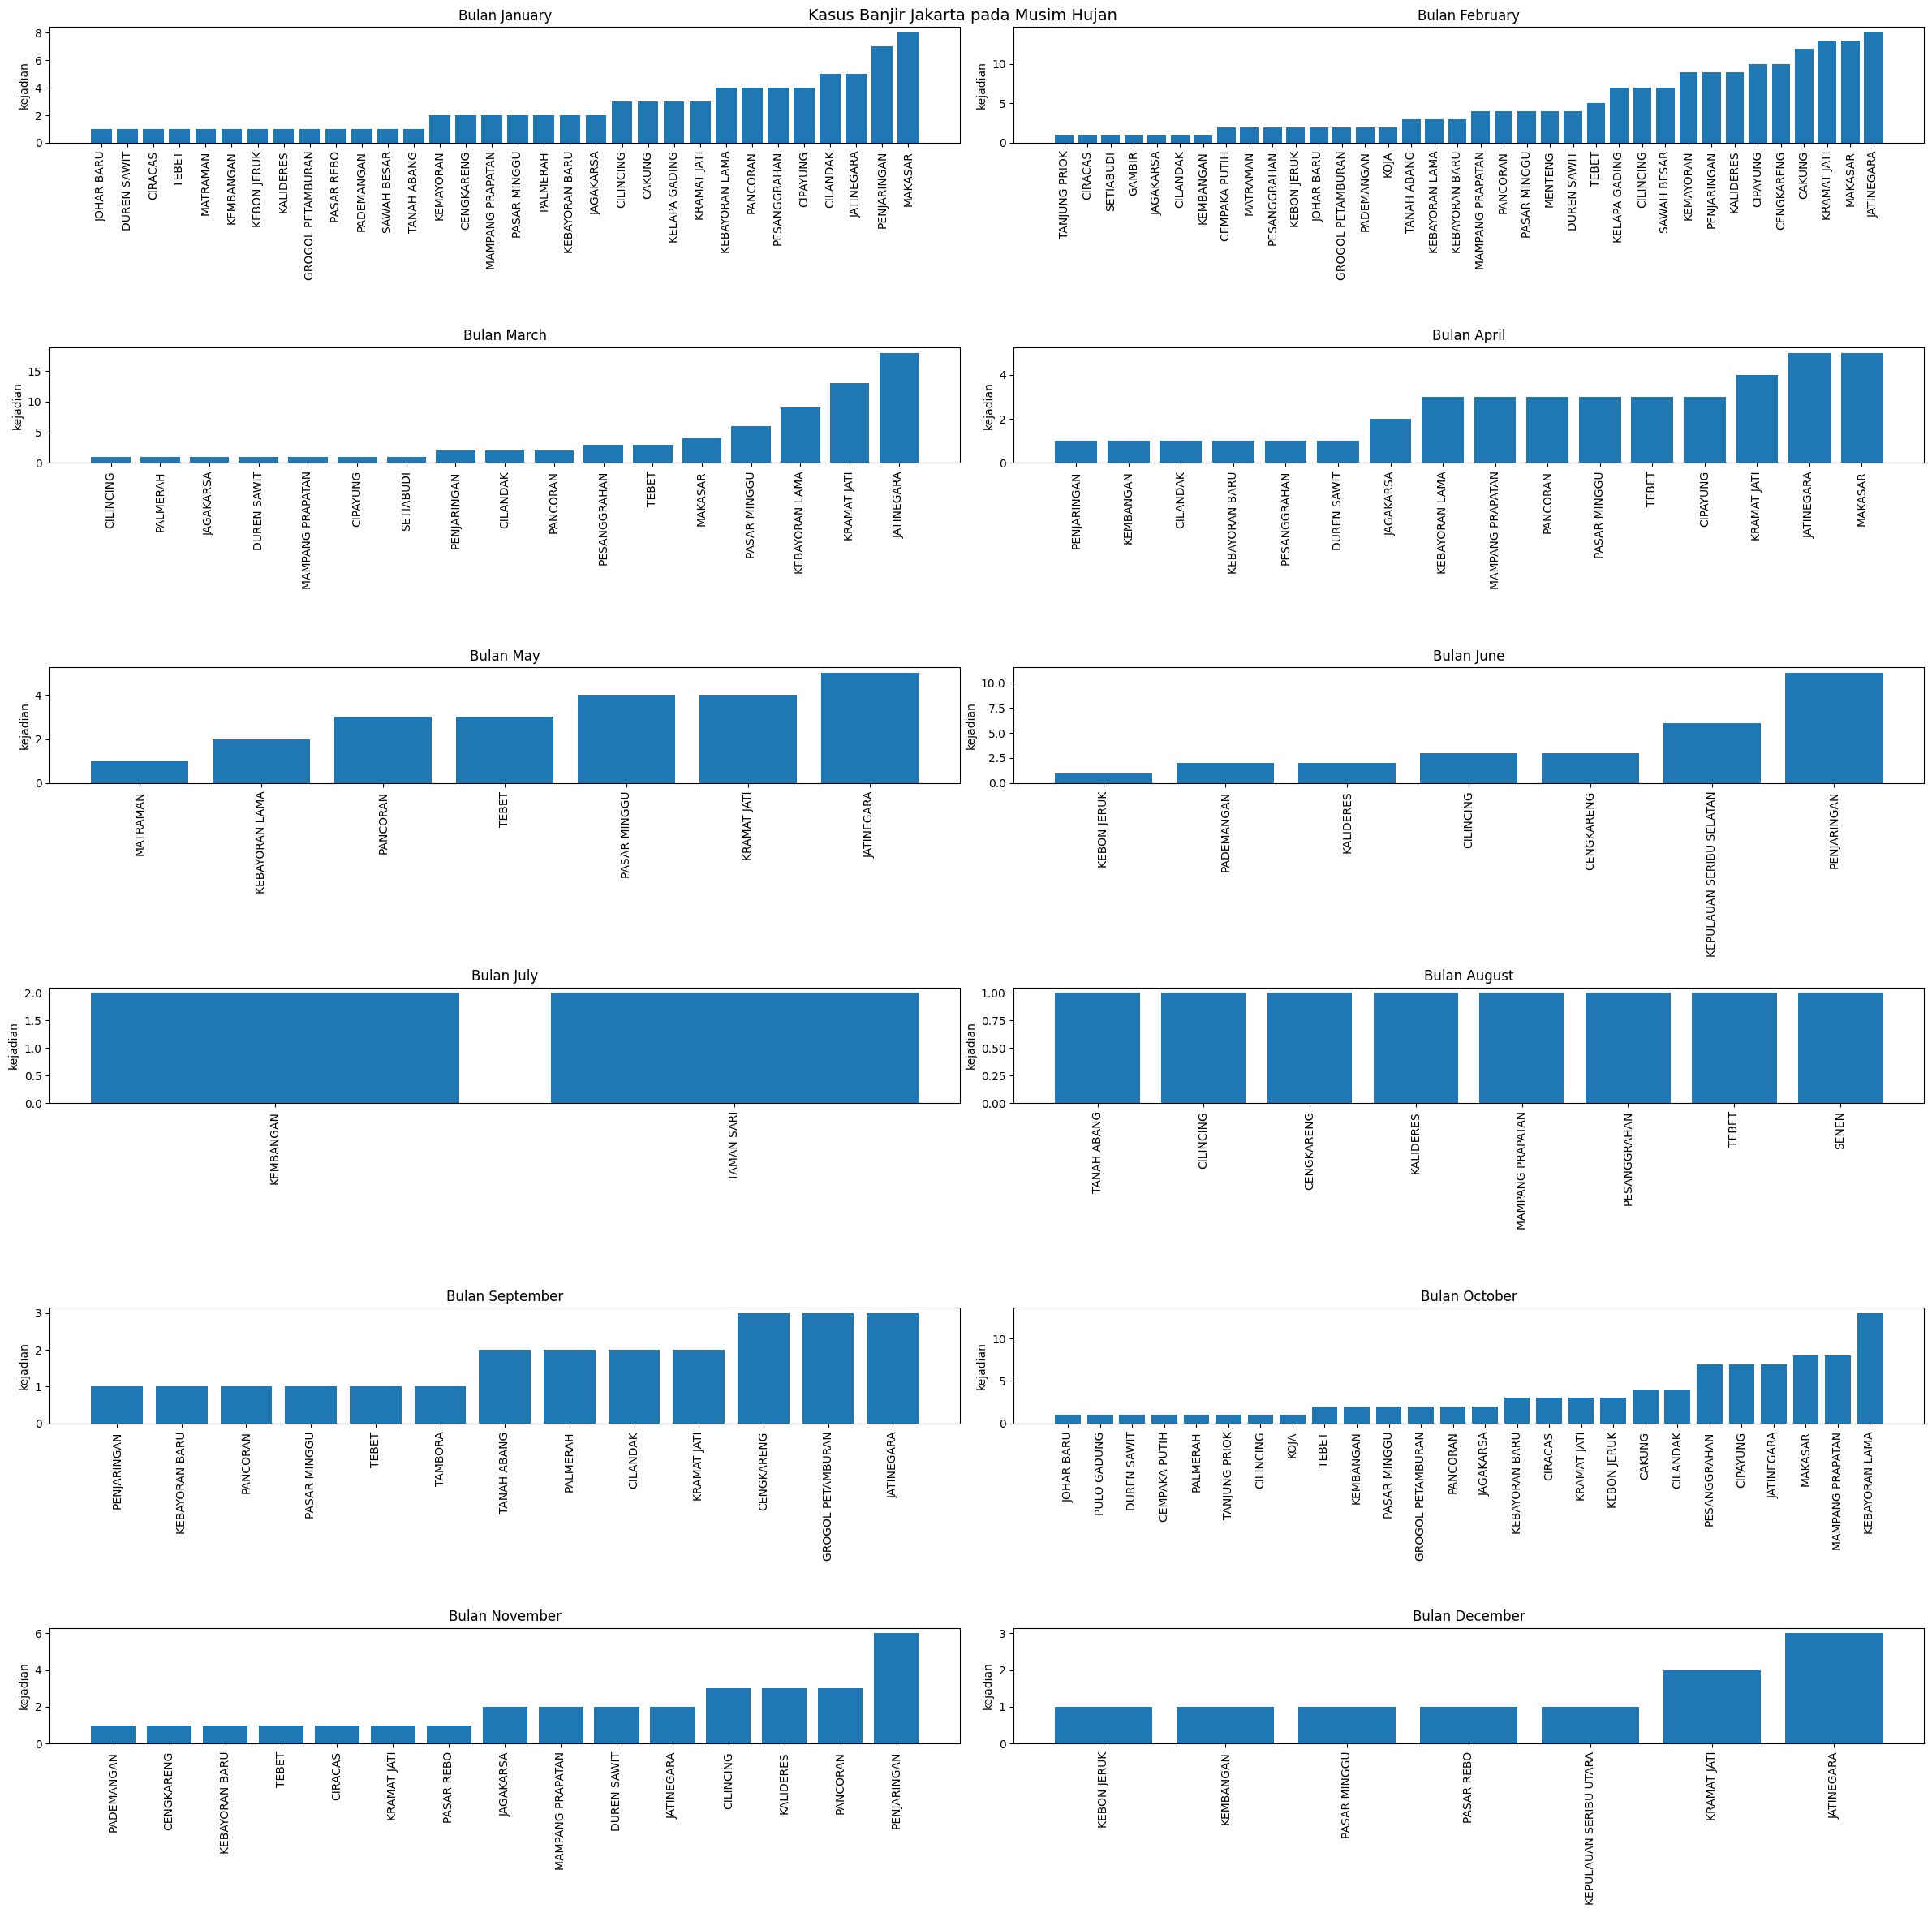

In [16]:

printBarPlot3('kecamatan', 'kejadian',[0,1,2,3,4,5,6,7,8,9,10,11], *kasus_banjir_per_bulan_kecamatan)

In [17]:
all_combined = pd.DataFrame(columns=['kecamatan', 'bulan', 'jumlah_kejadian'])
for enum, bulan in enumerate(kasus_banjir_per_bulan_kecamatan, 1):
    for index, row in bulan.iterrows():
        all_combined.loc[-1] = [row['kecamatan'],enum,  row['kejadian']]
        all_combined.index += 1
        all_combined = all_combined.sort_index()


In [ ]:
all_combined.sort_values(by='jumlah_kejadian', ascending=[False])

In [20]:
# total_value_rainy_month = dict()
# for k in kasus_banjir_per_bulan_kecamatan:
#     for row in k.itertuples():
#         try:
#             total_value_rainy_month[row.kecamatan]
#         except KeyError:
#             total_value_rainy_month[row.kecamatan] = row.kejadian
#         finally:
#             total_value_rainy_month[row.kecamatan] += row.kejadian


In [21]:
# total_value_rainy_month = pd.Series(total_value_rainy_month).reset_index()
# total_value_rainy_month.columns = ['kecamatan', 'total_kejadian']

In [22]:
# all_combined = pd.DataFrame(columns=['kecamatan', 'jumlah_kejadian', 'bulan'])
# for enum, bulan in enumerate(total_value_rainy_month, 1):
#     for index, row in bulan.iterrows():
#         all_combined.loc[-1] = [row['kecamatan'], enum, row['kejadian']]
#         all_combined.index += 1
#         all_combined = all_combined.sort_index()

In [79]:


# Load the dataframe
df = for_modeling

# Split the data into features and target variable
X = df[['kecamatan', 'bulan', 'jumlah_terdampak_rw', 'jumlah_terdampak_rt','jumlah_terdampak_kk', 'jumlah_terdampak_jiwa']]
y = df['jumlah_kejadian_banjir']

# One-hot encode the city column
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Machine': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Multi-layer Perceptron': MLPRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Model: {name}')
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    print('---------------------')

Model: Linear Regression
Mean Squared Error: 7.740838533335837e+23
R^2 Score: -2.4615218767093036e+23
---------------------
Model: Decision Tree
Mean Squared Error: 8.657894736842104
R^2 Score: -1.7531380753138075
---------------------
Model: Random Forest
Mean Squared Error: 2.9606342105263157
R^2 Score: 0.058543096234309644
---------------------
Model: Gradient Boosting
Mean Squared Error: 2.3169949963901186
R^2 Score: 0.26321498022740997
---------------------
Model: Support Vector Machine
Mean Squared Error: 2.546885958896633
R^2 Score: 0.19011157792408329
---------------------
Model: K-Nearest Neighbors
Mean Squared Error: 2.8442105263157895
R^2 Score: 0.09556485355648536
---------------------
Model: Multi-layer Perceptron
Mean Squared Error: 2.938805564341495
R^2 Score: 0.06548442305458724
---------------------


c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
